In [1]:
#from statsmodels.tsa.arima.model import ARIMA
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector,SelectKBest,SelectPercentile,SelectFromModel
from sklearn.preprocessing import OneHotEncoder, StandardScaler,RobustScaler,MinMaxScaler,MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import sklearn

sns.set(font_scale = 1.5, style = 'darkgrid', palette = 'bright')
pd.set_option('display.max_columns', None)
warnings.filterwarnings(action = 'ignore')
sklearn.set_config(display = 'diagram')
np.random.seed(seed = 42)

from sklearn.decomposition import PCA
from random import random as rnd
import math

In [2]:
# Reading the datasets
sales_df = pd.read_csv('sales-forecasting.csv')
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')

In [3]:
# Removing columns with excessive missing values
sales_df.dropna(axis=1, thresh=int(sales_df.shape[0] * 0.6), inplace=True)
stores_df.dropna(axis=1, thresh=int(stores_df.shape[0] * 0.6), inplace=True)
features_df.dropna(axis=1, thresh=int(features_df.shape[0] * 0.6), inplace=True)

In [4]:
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [11]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,211.350143,8.106,False


In [5]:
merged_df = sales_df.merge(stores_df, on='Store').merge(features_df.drop(columns='IsHoliday'), on=['Store', 'Date'])

In [14]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,211.096358,8.106


In [6]:
merged_df['Date']=pd.to_datetime(merged_df['Date'])

In [7]:
merged_df.columns=merged_df.columns.str.strip()
merged_df.columns=merged_df.columns.str.capitalize()
merged_df['Type']=merged_df.select_dtypes(include=['object','category']).apply(lambda x: x.str.strip())

In [8]:
merged_df['Month'] = pd.to_datetime(merged_df['Date']).dt.month
merged_df['Day'] = pd.to_datetime(merged_df['Date']).dt.day
merged_df['Year'] = pd.to_datetime(merged_df['Date']).dt.year

In [9]:
month_dict ={
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}
merged_df['Month'] = merged_df['Month'].map(month_dict)

In [10]:
merged_df.drop_duplicates(inplace=True)

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_sales  421570 non-null  float64       
 4   Isholiday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_price    421570 non-null  float64       
 9   Cpi           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  Month         421570 non-null  object        
 12  Day           421570 non-null  int64         
 13  Year          421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(5), object(2)
memor

In [12]:
merged_df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_sales    0
Isholiday       0
Type            0
Size            0
Temperature     0
Fuel_price      0
Cpi             0
Unemployment    0
Month           0
Day             0
Year            0
dtype: int64

In [22]:
merged_df.head()

,Store,Dept,Date,Weekly_sales,Isholiday,Type,Size,Temperature,Fuel_price,Cpi,Unemployment,Month,Day,Year
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106,February,5,2010
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,211.096358,8.106,February,5,2010
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,211.096358,8.106,February,5,2010
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,211.096358,8.106,February,5,2010
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,211.096358,8.106,February,5,2010


In [23]:
merged_df.describe()

,Store,Dept,Date,Weekly_sales,Size,Temperature,Fuel_price,Cpi,Unemployment,Day,Year
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375360,15981.258123,136727.915739,60.090059,3.361027,171.201947,7.960289,15.673131,2010.968591
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,34875.000000,-2.060000,2.472000,126.064000,3.879000,1.000000,2010.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,93638.000000,46.680000,2.933000,132.022667,6.891000,8.000000,2010.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,140167.000000,62.090000,3.452000,182.318780,7.866000,16.000000,2011.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,202505.000000,74.280000,3.738000,212.416993,8.572000,23.000000,2012.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,219622.000000,100.140000,4.468000,227.232807,14.313000,31.000000,2012.000000
std,12.785297,30.492054,NaN,22711.183519,60980.583328,18.447931,0.458515,39.159276,1.863296,8.753549,0.796876


In [13]:
merged_df.to_csv('cleaned_data.csv' , index=False)

<AxesSubplot:>

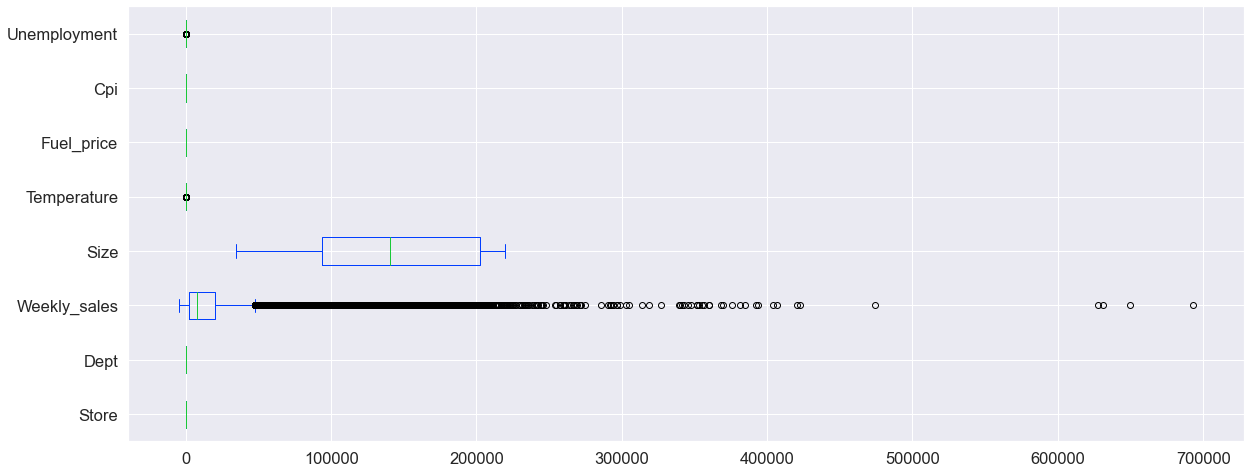

In [26]:
merged_df.select_dtypes(include=["int64","float"]).plot(kind="box",vert=False,figsize=(20,8))

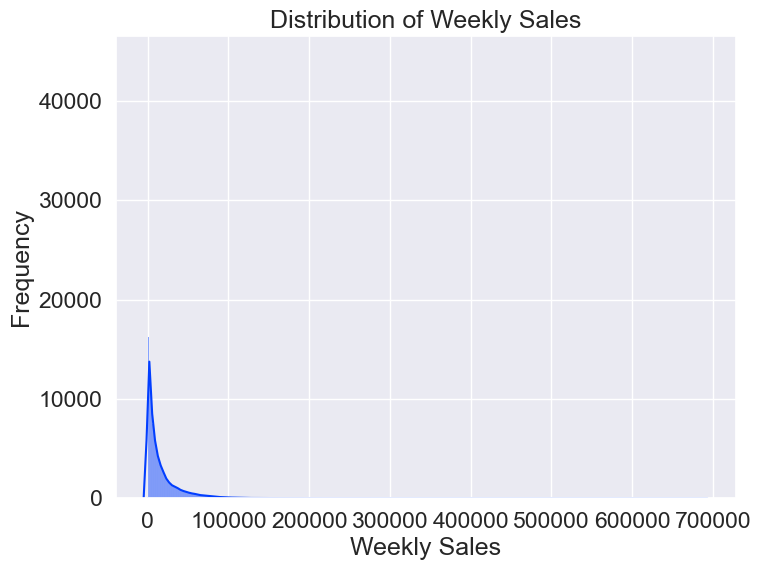

In [26]:
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['Weekly_sales'], kde=True)
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Weekly Sales')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
correlation_matrix = merged_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
sns.barplot(x = "Isholiday_x", y = merged_df.Weekly_sales, data= merged_df);

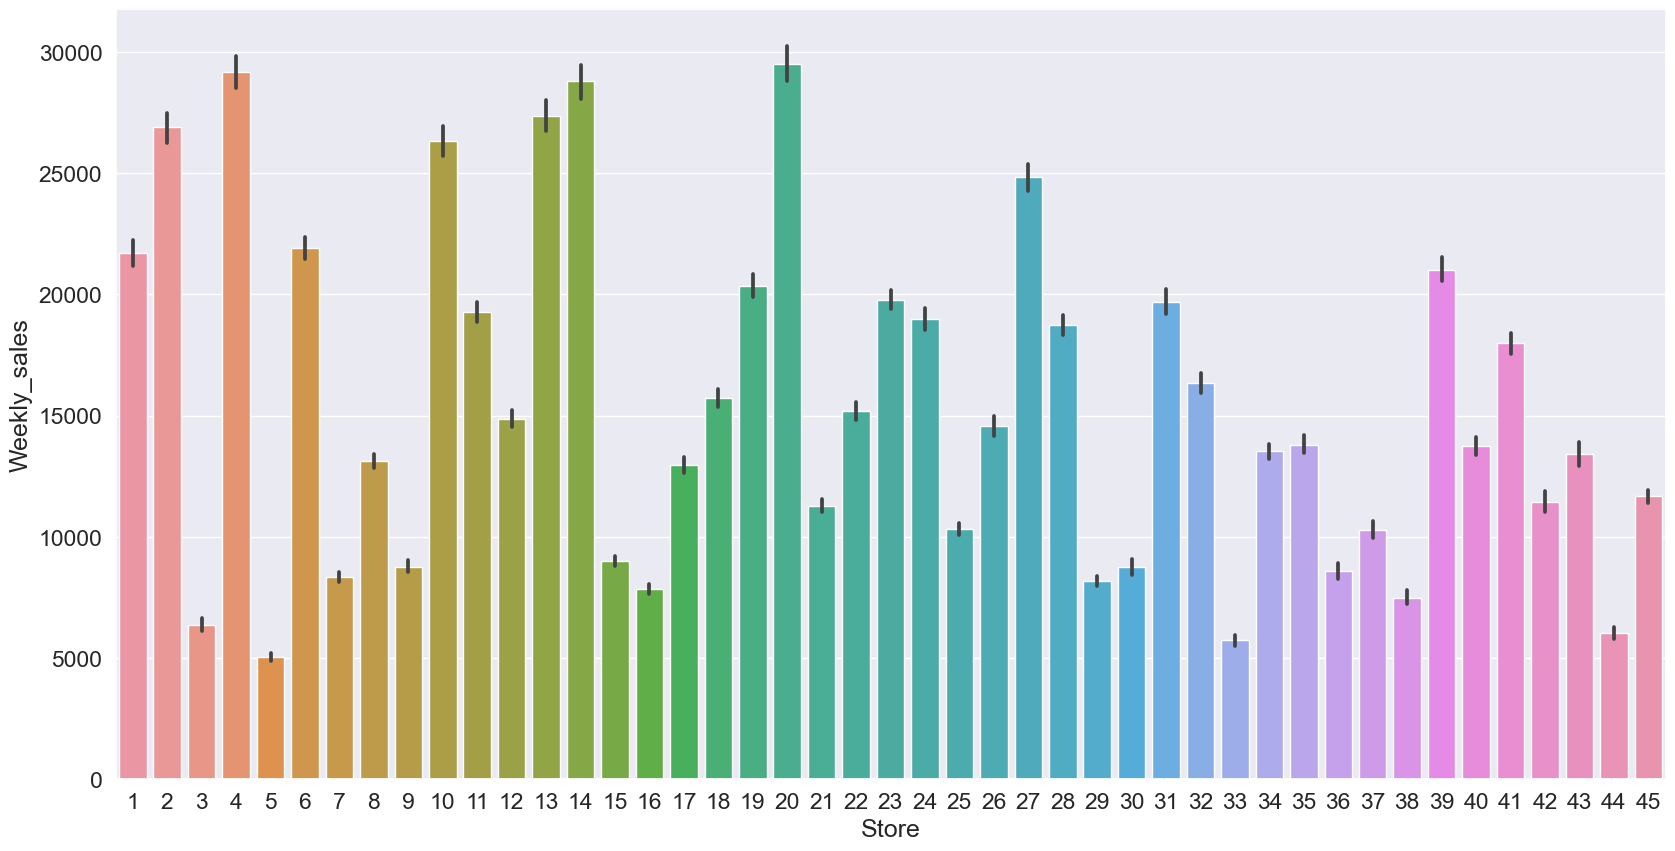

In [22]:
plt.figure(figsize=(20,10))
sns.barplot(x = "Store", y = merged_df.Weekly_sales, data= merged_df);

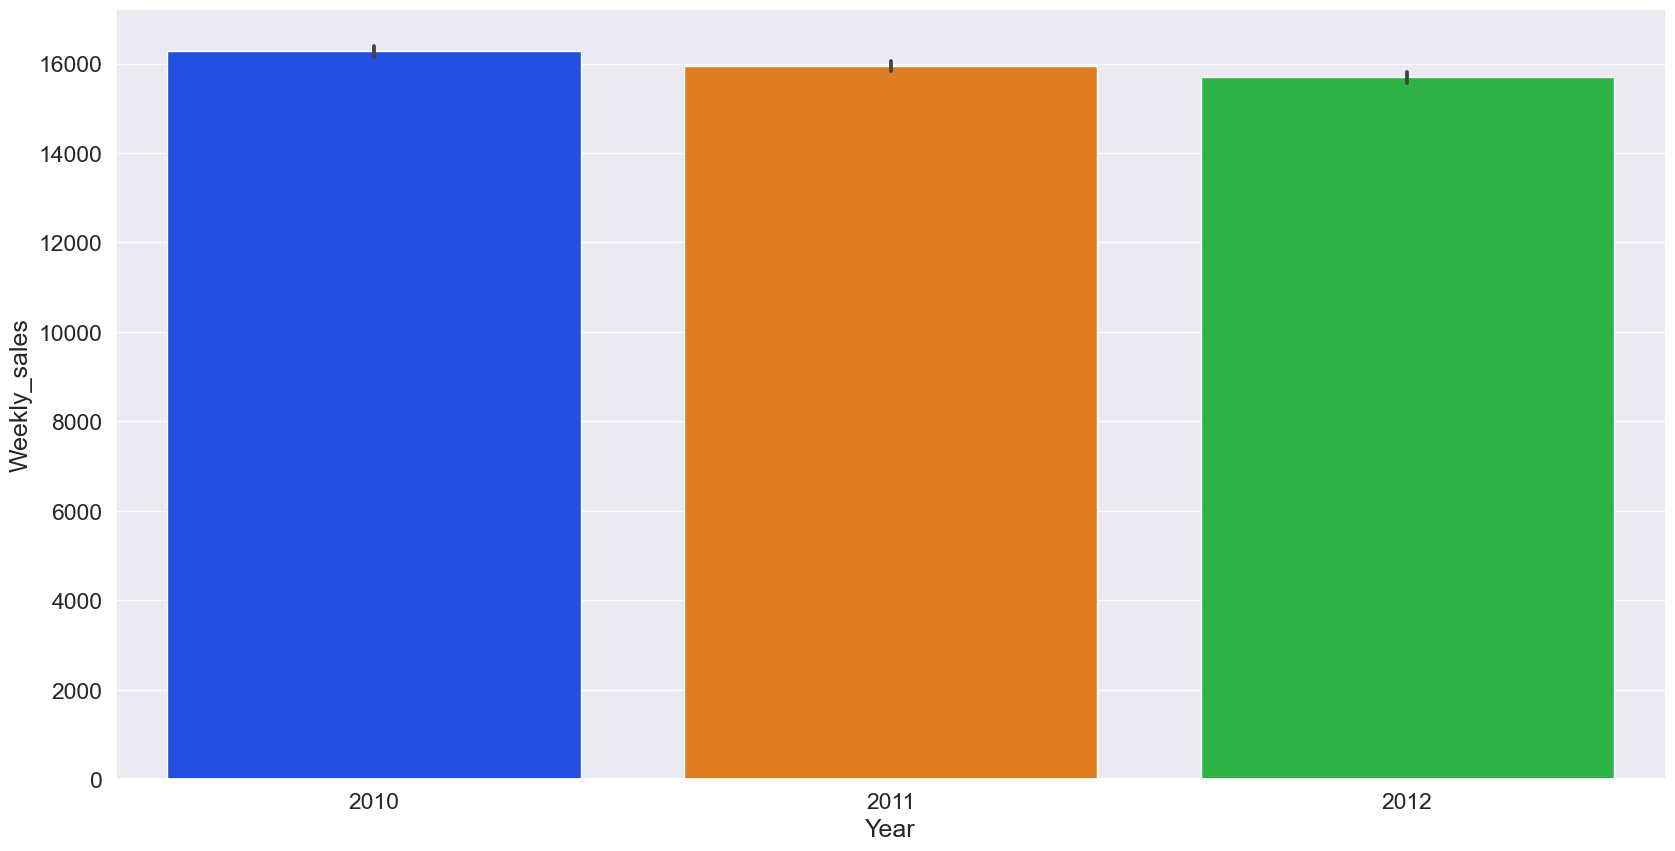

In [23]:
plt.figure(figsize=(20,10))
sns.barplot(x = "Year", y = merged_df.Weekly_sales, data= merged_df);

# Feature engineering Model Selection via pipeline method

In [14]:
from sklearn.preprocessing import LabelEncoder
merged_df['Isholiday']=LabelEncoder().fit_transform(merged_df['Isholiday'])

In [15]:
merged_df=merged_df.sort_values(by='Date')

In [16]:
sampled_data=merged_df.sample(100 , random_state=42)

In [17]:
sampled_data=sampled_data.sort_values(by='Date')

In [18]:
sampled_data=sampled_data.reset_index().drop(columns='index')

In [19]:
sampled_data.head()

,Store,Dept,Date,Weekly_sales,Isholiday,Type,Size,Temperature,Fuel_price,Cpi,Unemployment,Month,Day,Year
0,24,5,2010-02-12,37203.40,1,A,203819,25.94,2.940,131.586613,8.326,February,12,2010
1,23,46,2010-02-12,34803.69,1,B,114533,18.75,2.771,131.586613,5.892,February,12,2010
2,20,94,2010-03-05,55829.57,0,A,203742,31.75,2.777,204.494073,8.187,March,5,2010
3,38,16,2010-03-12,740.85,0,C,39690,50.11,2.925,126.604286,13.975,March,12,2010
4,7,28,2010-03-26,238.54,0,B,70713,23.33,2.717,189.719542,9.014,March,26,2010


In [22]:
x=sampled_data.drop(columns='Weekly_sales')
y=sampled_data['Weekly_sales']

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [24]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((80, 13), (20, 13), (80,), (20,))

In [25]:
# SequentialFeatureSelector() metodundan istifadə edərək ən vacib dəyişənlərin seçilməsi üçün metodun yaradılması
rkf = RepeatedKFold(random_state = 42)
regression=XGBRegressor(random_state=42)

# make_column_selector() metodu ilə təyin olunmuş data növünə əsasən sütunların seçilməsi
categoric_features = make_column_selector(dtype_include = 'object')
numeric_features = make_column_selector(dtype_include = 'number')

feature_selector = SequentialFeatureSelector(estimator = regression, scoring = 'r2', cv = rkf, n_jobs = -1)
# Pipeline() metodu ilə kateqorik data növlü dəyişənlər üçün spesifik boru əməliyyatlarının yaradılması
categoric_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')), ('ohe', OneHotEncoder(handle_unknown = 'ignore'))])

# Pipeline() metodu ilə numerik data növlü dəyişənlər üçün spesifik boru əməliyyatlarının yaradılması
numeric_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), ('scaler', MinMaxScaler()),('pca', PCA(random_state=42))])

# ColumnTransformer() metodu ilə sütunlara data növünə əsasən öncədən yaradılmış boru əməliyyatlarının tətbiq olunması
transformer = ColumnTransformer(transformers = [('categoric_transformer', categoric_transformer, categoric_features),
                                                ('numeric_transformer', numeric_transformer, numeric_features)], n_jobs = -1)

# Pipeline() metodu ilə boru modelinin qurulması
pipe = Pipeline(steps = [('transformer', transformer), ('feature_selector', feature_selector), ('regressor', regression)])
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('categoric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015FD9FA4DC0>),
                                                 ('numeric_transformer',
                                                  Pipeline(steps=[('imputer'...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [26]:
pipe.fit(X = x_train, y = y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('categoric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015FD9FA4DC0>),
                                                 ('numeric_transformer',
                                                  Pipeline(steps=[('imputer'...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

# Model Tuning

In [27]:
def build_pipe(data_frame=None, hyperparameters=None, n_iterations=50, metric=None):
    categoric = make_column_selector(dtype_include='object')
    numeric = make_column_selector(dtype_include='number')

    numeric_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', MinMaxScaler()),
                                        ('pca', PCA(random_state=42))])

    categoric_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('ohe', OneHotEncoder(handle_unknown='ignore'))])

    feature_transformer = ColumnTransformer(transformers=[('categoric_transformer', categoric_transform, categoric),
                                                          ('numeric_transformer', numeric_transform, numeric)])

    pipe = Pipeline(steps=[('transformer', feature_transformer),
                           ('regressor', XGBRegressor())])

    bayes_search = skopt.BayesSearchCV(estimator=pipe, search_spaces=hyperparameters,
                                       n_iter=n_iterations, scoring=metric, n_jobs=-1, random_state=42)
    bayes_search.fit(sampled_data.drop(columns=['Weekly_sales'], axis=1), sampled_data['Weekly_sales'])

    return bayes_search.best_estimator_

In [28]:
import skopt
search_spaces = {
    'transformer__categoric_transformer__imputer__strategy': skopt.space.Categorical(categories=['constant', 'most_frequent']),
    'transformer__numeric_transformer__imputer__strategy': skopt.space.Categorical(categories=['mean', 'median']),
    'transformer__numeric_transformer__scaler': skopt.space.Categorical(categories=[RobustScaler(), MinMaxScaler(), MaxAbsScaler(), StandardScaler()]),
    'transformer__numeric_transformer__pca__n_components': skopt.space.Integer(low=1, high=3)
}

In [29]:
model = build_pipe(data_frame = sampled_data, hyperparameters = search_spaces, metric = 'r2')
model

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('categoric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015FE0B6B910>),
                                                 ('numeric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [30]:
# score() metodundan istifadə edərək reqressiya modelinin train və test datasına görə performansının hesablanması
train_score = model.score(x_train, y_train)
test_score = model.score(x_test,y_test)

# Reqressiya modelinin train və test datasına görə performansının göstərilməsi
print(f'Model R2 score on train set: {train_score:.4f}')
print(f'Model R2 score on test set: {test_score:.4f}')

Model R2 score on train set: 1.0000
Model R2 score on test set: 1.0000


In [31]:
# Test datası üzərində proqnoz
prediction = model.predict(x_test)

# Qiymətləndirmə metriklərinn hesablanması
mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
rmse = np.sqrt(mean_squared_error(y_test,prediction))
r2 = r2_score(y_test, prediction)

print(f'Mean Squared Error on test set: {mse:.4f}')
print(f'Mean Absolute Error on test set: {mae:.4f}')
print(f'Root Mean Squared Error on test set: {rmse:.4f}')
print(f'R2 score on test set: {r2:.4f}')

Mean Squared Error on test set: 17.3776
Mean Absolute Error on test set: 3.3228
Root Mean Squared Error on test set: 4.1686
R2 score on test set: 1.0000


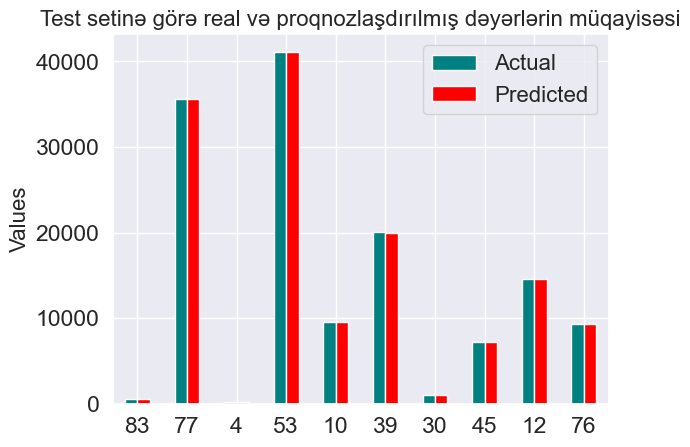

In [32]:
np.random.seed(seed = 42)

# Test seti üçün real və proqnozlaşdırılan dəyərlərin müqayisəsi
pd.DataFrame(data = {'Actual':y_test, 'Predicted':prediction}).sample(n = 10).plot(kind = 'bar', color = ['teal', 'red'])
plt.title(label = 'Test setinə görə real və proqnozlaşdırılmış dəyərlərin müqayisəsi', fontsize = 16)
plt.ylabel(ylabel = 'Values', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.xticks(rotation = 0)
plt.show()

In [35]:
import pickle
# Save the model to a pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [36]:
#load model
# Load the model from the pickle file
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [38]:
model

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('categoric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000016380398B80>),
                                                 ('numeric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImp...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])